# Exploring TEACh Data

In [4]:
import os
import sys
import json
import copy

sys.path.append("../../")

In [5]:
from teach.dataset.definitions import Definitions
from teach.dataset.dataset import Dataset
from teach.dataset.actions import Action_Keyboard, Action_ObjectInteraction

In [61]:
# Edit data directory if changed when using `teach_download`
# data_dir = "/tmp/teach-dataset"
data_dir = "/data/anthony/teach"

### Definitions

Instantiate a `Definitions` object to access various definitions, mappings of agent IDs and actions to names, as well as task definitions. 
The code uses `Driver` when referring to the `Follower` in the paper. 

In [12]:
definitions = Definitions(version="2.0")
print("Agent IDs to agents: ", definitions.map_agents_id2info)
print("Status IDs to names: ", definitions.map_status_id2name)

Agent IDs to agents:  OrderedDict([(0, OrderedDict([('agent_name', 'Commander'), ('agent_type', 0)])), (1, OrderedDict([('agent_name', 'Driver'), ('agent_type', 1)]))])
Status IDs to names:  OrderedDict([(0, 'Success'), (1, 'Failure')])


Display mappings of action IDs to action names. Note that only a subset of these are used in TEACh data. Note that `definitions.map_tasks_name2info` ends up being more useful when trying to access actions by name. 

In [13]:
print("Action IDs to names:")
for action_id, action in definitions.map_actions_id2info.items():
    print("\t ", action_id, ":", action["action_name"])

Action IDs to names:
	  0 : Stop
	  1 : Move to
	  2 : Forward
	  3 : Backward
	  4 : Turn Left
	  5 : Turn Right
	  6 : Look Up
	  7 : Look Down
	  8 : Pan Left
	  9 : Pan Right
	  10 : Move Up
	  11 : Move Down
	  12 : Double Forward
	  13 : Double Backward
	  300 : Navigation
	  200 : Pickup
	  201 : Place
	  202 : Open
	  203 : Close
	  204 : ToggleOn
	  205 : ToggleOff
	  206 : Slice
	  207 : Dirty
	  208 : Clean
	  209 : Fill
	  210 : Empty
	  211 : Pour
	  212 : Break
	  400 : BehindAboveOn
	  401 : BehindAboveOff
	  500 : OpenProgressCheck
	  501 : SelectOid
	  502 : SearchObject
	  100 : Text
	  101 : Speech
	  102 : Beep


Tasks are also most convenient to access by name via `definitions.map_tasks_name2info` but can be accessed via ID using `definitions.map_tasks_id2info`. The values of both of these dictionaries are of type `Task_THOR`.  

When a `Definitions` object is instantiated, all tasks defined under `src/teach/meta_data_files/task_definitions` get loaded. The Task Definition Language is explained in Appendix F of the [TEACh paper](https://arxiv.org/pdf/2110.00534.pdf). To create a new task, create a new JSON file under `src/teach/meta_data_files/task_definitions`. Each task needs to have a unique `task_id` and `task_name`. Tasks can be referenced in other tasks by their `task_name`. After creating a new task, test that it can be loaded any any inter-task dependencies can be resolved by instantiating a `Definitions` object.

The following code snippet demonstrates how to print a few task details. Note that `#n` (where `n` is a number) indicates a variable.

In [14]:
print("Task details by name:")
print("Task name".ljust(33, " "), "Task ID".ljust(10, " "), "Num task params".ljust(20, " "), "Task component names")
for task_name, task in definitions.map_tasks_name2info.items():
    print(
        task_name.ljust(35, " "),
        str(task.task_id).ljust(15, " "),
        str(task.task_nparams).ljust(10, " "),
        str(list(task.components.keys())),
    )

Task details by name:
Task name                         Task ID    Num task params      Task component names
Sandwich                            302             2          ['toast', 'lettuce', 'tomato', 'plate']
Water Plant                         114             0          ['water_plant']
Basic Bathroom Tasks                403             0          ['faucets', 'candles', 'soap', 'counter']
Boil X                              112             1          ['boiled_#0']
Coffee                              102             0          ['coffee']
Workspace                           305             3          ['writing', 'laptop', 'book', 'gather_spot', 'lights']
Poach Egg                           113             0          ['poached_egg']
N Slices Of X In Y                  108             4          ['#1', '#3']
Sliced X                            104             1          ['#0', 'knife']
Candles                             304             0          ['candles', 'bathtub']
Plate Of Toast 

### Gameplay Sessions
Gameplay sessions are stored in `json` files. The `games` subdirectory consists of one subdirectory per split each containing game files of that split. When loaded, these are dictionaries and for many purposes, it is sufficient to analyze the dictionaries. Some examples:   

In [15]:
f = os.path.join(data_dir, "games/train/7d2a79f43e605c36_1657.game.json")
with open(f) as h:
    game_dict = json.load(h)
print(game_dict.keys())

dict_keys(['version', 'task_type', 'comments', 'definitions', 'tasks'])


While the game dictionary contains other keys, the important one is `tasks`. `version`, `task_type` and `comments` are dataset-specific metadata, and `definitions` contains the version of the `Definitions` object used to collect the data. However, all games in the subdirectory `games` have been verified to be replayable and resulting in task success using the current (released) version of the `Definitions` object. `tasks` is always a list of length 1 in this dataset.  

In [16]:
print(game_dict["tasks"][0].keys())

dict_keys(['task_id', 'task_name', 'task_params', 'task_nparams', 'task_anchor_object', 'desc', 'components', 'relations', 'comments', 'episodes'])


This is a dictionary that can be converted to a `Task_THOR` object. All keys except `episodes` are associated with the task definition and can be better understood by reading Appendix F of the [TEACh paper](https://arxiv.org/pdf/2110.00534.pdf). For all game files in this dataset `game_dict['tasks'][0]['episodes']` will be a list of length 1 and `game_dict['tasks'][0]['episodes'][0]` contains the actual sequence of actions taken in the episode. 

In [17]:
print(game_dict["tasks"][0]["episodes"][0].keys())

dict_keys(['episode_id', 'world', 'world_type', 'commander_embodied', 'initial_state', 'interactions', 'final_state'])


Episodes are used to store the initial and final simulator state, as well as the sequence of actions taken in a gameplay session. The components of an episode are:
* `episode_id` - A unique id
* `world_type` - Type of room which is one of `Kitchen`, `Bedroom`, `Bathroom` and `Living room` 
* `world` - ID of the specific AI2-THOR floor plan used for this gameplay session
* `commander_embodied` - False for all TEACh games
* `initial_state`, `final_state` - Dictionaries consisting of the initial and final state of the world including
    * `time_start` - 
    * `agents` - Position and orientation of each agent/ camera at start and end of episode
    * `objects` - A list of the state of all objects at the start and end of the episode. Each object is represented by a dictionary whose keys are property names and values are property values.
    * `custom_object_metadata` - A dictionary to track custom properties in our codebase that are not present in AI2-THOR. This is a dictionary with AI2-THOR objectId as key and a dictionary of (custom_property_name, custom_property_value) pairs as values
* `interactions` - An ordered list of interactions that occurred in the environment, each represented by a dictionary of
    * `agent_id` - The agent that took the action
    * `action_id` - Which action was taken
    * `time_start` - Duration of time between start of episode and when this action started
    * `duration` - Duration of time (in sec) taken to execute this action
    * `success` - 1 if the action was successfully executed during data collection and 0 otherwise. An example of a case where `success` might be 0 is if the human annotator tried to pick up an object from too far away 
    * Action specific keys. Some examples include
        * `utterance` for a `Text` action - Stores the text value of the utterance made
        * `pose_delta` and `pose` for a navigation action
        * `commander_obs` - relative file path to the commander's observation
        * `driver_obs` - relative file path to the driver's observation
        * `pc_json` - relative file path to the commander's progress check output
        * `targetobject_frame` - relative file path to the target object's frame, when commander executes a search query
        * `targetobject_mask` - relative file path to a binary mask of the target object
        
Code snippet to print out the sequence of actions taken in an episode:

In [18]:
def print_actions_from_game_dict(game_dict, definitions):
    interactions = game_dict["tasks"][0]["episodes"][0]["interactions"]
    print(
        "Time Start",
        "Action Success".ljust(15, " "),
        "Agent".ljust(15, " "),
        "Action".ljust(20, " "),
        "Utterance text / Object ID / Object X, Y",
    )
    for interaction in interactions:
        output_str = "".rjust(2, " ")
        output_str += ("%.2f" % interaction["time_start"]).ljust(15, " ")
        output_str += str(interaction["success"]).ljust(10, " ")
        output_str += definitions.map_agents_id2info[interaction["agent_id"]]["agent_name"].ljust(15, " ")
        output_str += definitions.map_actions_id2info[interaction["action_id"]]["action_name"].ljust(20, " ")
        if "utterance" in interaction:
            output_str += interaction["utterance"]
        elif "oid" in interaction and interaction["oid"] is not None:
            output_str += interaction["oid"]
        elif "x" in interaction and "y" in interaction:
            output_str += "(" + str(interaction["x"]) + ", " + str(interaction["y"]) + ")"
        print(output_str)

In [19]:
print_actions_from_game_dict(game_dict, definitions)

Time Start Action Success  Agent           Action               Utterance text / Object ID / Object X, Y
  15.29          0         Commander      OpenProgressCheck   
  27.85          1         Commander      Text                I need the newspaper to be placed on a single table.
  29.49          1         Commander      SelectOid           
  39.11          1         Driver         Text                what should i do
  61.21          1         Driver         Pan Left            
  61.59          1         Driver         Pan Left            
  61.84          1         Driver         Pan Left            
  62.12          1         Commander      Text                I need the newspaper placed on a single table.
  70.16          1         Driver         Pickup              Newspaper|-04.15|+00.36|-02.48
  87.74          1         Driver         Place               CoffeeTable|-02.47|+00.00|-02.49
  92.55          1         Commander      OpenProgressCheck   


Note that for all object interactions, the relative coordinates of the object on the agent's egocentric image are available in `interaction['x'], interaction['y']`. In the cases where the wrapper was able to resolve these to an object ID using the segmentation frame, we also have the ID of the object interacted with in `interaction['oid']` but if the wrapper was forced to backoff to raycasting, then this is not available.   

It is also possible to import a game file into a `Dataset` object as follows.

In [20]:
f = os.path.join(data_dir, "games/train/7d2a79f43e605c36_1657.game.json")
game = Dataset.import_json(f)

The following is how the code snippet to print out the same action info would look using the object oriented representation:

In [21]:
def print_actions_from_game_as_dataset(game, definitions):
    interactions = game.tasks[0].episodes[0].interactions
    print(
        "Time Start",
        "Action Success".ljust(15, " "),
        "Agent".ljust(15, " "),
        "Action".ljust(20, " "),
        "Utterance text / Object ID / Object X, Y",
    )
    for interaction in interactions:
        output_str = "".rjust(2, " ")
        output_str += ("%.2f" % interaction.time_start).ljust(15, " ")
        output_str += str(interaction.status).ljust(10, " ")
        output_str += definitions.map_agents_id2info[interaction.agent_id]["agent_name"].ljust(15, " ")
        output_str += definitions.map_actions_id2info[interaction.action.action_id]["action_name"].ljust(20, " ")
        if isinstance(interaction.action, Action_Keyboard):
            output_str += interaction.action.utterance
        if isinstance(interaction.action, Action_ObjectInteraction):
            if interaction.action.oid is None:
                output_str += "(" + str(interaction.action.x) + ", " + str(interaction.action.y) + ")"
            else:
                output_str += interaction.action.oid
        print(output_str)

In [22]:
print_actions_from_game_as_dataset(game, definitions)

Time Start Action Success  Agent           Action               Utterance text / Object ID / Object X, Y
  15.29          None      Commander      OpenProgressCheck   
  27.85          None      Commander      Text                I need the newspaper to be placed on a single table.
  29.49          None      Commander      SelectOid           
  39.11          None      Driver         Text                what should i do
  61.21          None      Driver         Pan Left            
  61.59          None      Driver         Pan Left            
  61.84          None      Driver         Pan Left            
  62.12          None      Commander      Text                I need the newspaper placed on a single table.
  70.16          None      Driver         Pickup              Newspaper|-04.15|+00.36|-02.48
  87.74          None      Driver         Place               CoffeeTable|-02.47|+00.00|-02.49
  92.55          None      Commander      OpenProgressCheck   


Note that while the object oriented representation of the game can be manipulated more easily in the code, the task of the game does not get perfectly loaded. Specifically, when loading a game file, no attempt is made to resolve components of tasks that are themselves tasks. Additionally, the final state does not get loaded. The following code snippet shows how to check whether the task associated with a gameplay session is complete at the final state, by directly loading the game json file as a dictionary. 

In [24]:
definitions = Definitions(version="2.0")
f = os.path.join(data_dir, "games/train/7d2a79f43e605c36_1657.game.json")
with open(f) as h:
    game_dict = json.load(h)
game_task = game_dict["tasks"][0]
task_to_check = copy.deepcopy(
    definitions.map_tasks_name2info[game_task["task_name"]]
)  # Copying is important if you're sharing a definitions object across calls
task_to_check.task_params = game_task["task_params"]
final_state_objects = game_dict["tasks"][0]["episodes"][0]["final_state"]["objects"]
task_check_output = task_to_check.check_episode_progress(final_state_objects)
print(task_check_output["success"])

True


# TATC Dataset

In [119]:
%load_ext autoreload
%autoreload 2

from pprint import pprint
from modeling.datasets.tatc import TATCDataset
from modeling.utils.helper_util import AttrDict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TATC dataset reads from the preprocessed pkl file that contains the task json and an lmdb dataset which contain the preprocessed visual features. This dataset class provides all the inputs necessary for training a model for the driver and commander class. 

In [6]:
dataset_args = AttrDict(
    fast_epoch=False,
    model="seq2seq_attn",
    lmdb_max_readers=1,
    no_lang=False,
    no_vision=False,
    compute_train_loss_over_history=True
)

dataset_name = "tatc_final"
phase = "train"
ann_type = "lang"

dataset = TATCDataset(dataset_name, phase, args, ann_type)

[MainThread-3239212-INFO] modeling.datasets.base: Visual checkpoint for data preprocessing: /data/anthony/teach/experiments/checkpoints/pretrained/fasterrcnn_model.pth


INFO:modeling.datasets.base:Visual checkpoint for data preprocessing: /data/anthony/teach/experiments/checkpoints/pretrained/fasterrcnn_model.pth


[MainThread-3239212-INFO] modeling.datasets.base: train dataset size = 1482


INFO:modeling.datasets.base:train dataset size = 1482


[MainThread-3239212-INFO] modeling.utils.data_util: In load_vocab, loading vocab from /data/anthony/teach/tatc_final/data.vocab


INFO:modeling.utils.data_util:In load_vocab, loading vocab from /data/anthony/teach/tatc_final/data.vocab


[MainThread-3239212-INFO] modeling.datasets.tatc: Loading object vocab from /home/anthony/teach/src/teach/modeling/vocabs/obj_cls.vocab


INFO:modeling.datasets.tatc:Loading object vocab from /home/anthony/teach/src/teach/modeling/vocabs/obj_cls.vocab


The dataset class contains the vocabulary that was generated during preprocessing. It is a dictionary containing the vocabulary for dialogue, commander and follower actions, and object classes. The vocabulary is used when converting from prediction tokens to actual commands for the simulation. 

In [121]:
vocab = dataset.vocab
print(vocab)

print('\nCommander Actions:')
pprint(vocab['commander_action_low'].to_dict()['index2word'])

print('\nFollower Actions:')
pprint(vocab['driver_action_low'].to_dict()['index2word'])

{'word': Vocab(2705), 'driver_action_low': Vocab(22), 'driver_action_high': Vocab(108), 'commander_action_low': Vocab(14), 'object_cls': Vocab(101)}

Commander Actions:
['OpenProgressCheck',
 'SelectOid',
 'SearchObject',
 'Text',
 'NoOp',
 'Look Up',
 'Pan Right',
 'Turn Left',
 'Turn Right',
 'Forward',
 'Pan Left',
 'Backward',
 'Look Down',
 'Navigation']

Follower Actions:
['Stop',
 'Forward',
 'Backward',
 'Turn Left',
 'Turn Right',
 'Look Up',
 'Look Down',
 'Pan Left',
 'Pan Right',
 'Navigation',
 'Pickup',
 'Place',
 'Open',
 'Close',
 'ToggleOn',
 'ToggleOff',
 'Slice',
 'Pour',
 'Text',
 'NoOp',
 'OpenProgressCheck',
 'SearchObject']


Every element in the TATCDataset is a tuple containing the game json and a dictionary of input features. The game json is described above.

The features that we provided include:
- `commander_lang` and `driver_lang`: tokenized commander and follower dialogue
- `commander_action` and `driver_action`: tokenized list of actions
- `object`: tokenized list of objects only if there is an interaction action
- `frames`: visual features extracted using a pretrained FasterRCNN vision extractor

We also show how to convert the tokenized lang / actions back into natural language using the vocabulary.

In [124]:
indx = 0
task_json, feat_dict = dataset[indx]

print('Task: ')
print(task_json['tasks'][0]['task_name'])

print('\nFeatures:')
print(list(feat_dict.keys()))


print('\nShape of the visual features:')
print(feat_dict['frames'].shape)

print('\nLength of commander and driver language tokens: ')
print(len(feat_dict['commander_action']), len(feat_dict['driver_action']))
print(len(feat_dict['commander_lang']), len(feat_dict['driver_lang']))

print('\nConverting from tokens to original dialogue:')

commander_lang, driver_lang, action_seq = "", "", ""
for token in feat_dict['commander_lang']:
    commander_lang += vocab['word'].index2word(token) + " "

for token in feat_dict['driver_lang']:
    driver_lang += vocab['word'].index2word(token) + " "

for i, _ in enumerate(feat_dict['commander_action']):
    commander_action = vocab['commander_action_low'].index2word(feat_dict['commander_action'][i])
    driver_action = vocab['driver_action_low'].index2word(feat_dict['driver_action'][i])
    action_seq += f"({commander_action}, {driver_action}) -> "

print('\nCommander dialogue: ')
print(commander_lang)

print('\nDriver dialogue: ')
print(driver_lang)

print('\nAction sequence: ')
print(action_seq)

Task: 
Breakfast

Features:
['commander_lang', 'driver_lang', 'commander_action', 'driver_action', 'object', 'frames']

Shape of the visual features:
torch.Size([387, 512, 7, 7])

Length of commander and driver language tokens: 
386 387
113 7

Converting from tokens to original dialogue:

Commander dialogue: 
<<commander>> good day ! we are preparing breakfast . we first need to wash a dirty mug . <<sent>> <<commander>> the mug is located under the sink <<sent>> <<commander>> oh you found one ! okay . <<sent>> <<commander>> great . we are making a sandwich . we need a knife to start . <<sent>> <<commander>> it is already on the dining table . <<sent>> <<commander>> you will need to use the toaster , so set it there <<sent>> <<commander>> next find bread . <<sent>> <<commander>> after you place the items on the plate . . . all breakfast items need to go to the table . <<sent>> <<commander>> all done ! <<sent>> <<stop>> 

Driver dialogue: 
<<driver>> done <<sent>> <<driver>> done <<sent>

# Visualize a game session

This can be done using the EpisodeReplay feature which also visualizes the target object frame and mask. 
Note: this will take a minute or two to run and generate the animation 

Number of interactions:  386


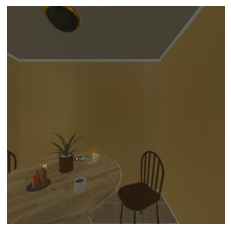

In [122]:
from matplotlib import animation
import matplotlib.image as mpimg
%matplotlib inline

# Suppress default INFO logging

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

fig = plt.figure()
commander_images, driver_images = [], []

# Visualize the first trajectory from the dataset
interactions = task_json['tasks'][0]['episodes'][0]['interactions']
print('Number of interactions: ', len(interactions))

for action in interactions:
    commander_obs_f = os.path.join(data_dir, action['commander_obs'])
    driver_obs_f = os.path.join(data_dir, action['driver_obs'])
    commander_img = mpimg.imread(commander_obs_f)
    driver_img = mpimg.imread(driver_obs_f)
    plot = plt.imshow(driver_img)
    plt.axis('off')
    driver_images.append([plot])

anim = animation.ArtistAnimation(fig, driver_images, interval=200, blit=True, repeat_delay=1000)
from IPython.display import HTML
HTML(anim.to_html5_video())

In [126]:
# Progress check outputs 
for action in interactions:
    print(action)
    if "action_name" in action:
        print("hi")
    break

{'agent_id': 0, 'action_id': 500, 'time_start': 40.5503203868866, 'duration': 1, 'success': 0, 'query': '', 'commander_obs': '/images/train/0008f3c95e006303_2053/commander.frame.40.5503203868866.jpeg', 'driver_obs': '/images/train/0008f3c95e006303_2053/driver.frame.40.5503203868866.jpeg', 'pc_json': '/prog_check_files/train/PC/0008f3c95e006303_2053/progresscheck.status.40.5503203868866.json'}
